# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [46]:
%matplotlib inline

In [47]:
from __future__ import print_function

In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
from ilqr import iLQR
from ilqr.cost import QRCost, FiniteDiffCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [50]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [51]:
dt = 0.04
pole_length = 1.0
dynamics = CartpoleDynamics(0.04, mc=0.25, l=0.3)

In [52]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))
print(x_goal)

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

[0. 0. 0. 1. 0.]


In [53]:
cost2 = FiniteDiffCost(lambda x, u, i: x[0]*(x[0]+x[2]) + x[2]*(x[0] + x[2]) + (x[3] - 1) * (x[3]-1) + 0.1 * u[0] * u[0],
                      lambda x, i: 100 * (x[0]**2 + x[1]**2 + x[2]**2 + (x[3] - 1)**2 + x[4]**2),
                      5, 1, x_eps = 1e-6, u_eps = 1e-6)

print(cost1.l([1.0,0.5,0.37,-0.4,3.0], [0.5], 0))
print(cost2.l([1.0,0.5,0.37,-0.4,3.0], [0.5], 0))

3.8619
3.8619


In [54]:
N = 100
x0 = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost2, N)

In [55]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 14776.076403825122 [-0.02851537 -0.26885463 -0.6582431  12.03767766]
iteration 1 accepted 14150.737571798527 [-0.01832312 -0.29374479 -0.51512495 11.78516185]
iteration 2 accepted 13614.166141175476 [-0.0509686  -0.38948544 -0.50625242 11.5533461 ]
iteration 3 accepted 13270.284168937224 [-0.16472606 -0.64845847 -0.49406455 11.392249  ]
iteration 4 accepted 12275.591399791456 [-0.12867153 -0.5486274  -0.55907876 10.95111592]
iteration 5 accepted 11646.963217089622 [-0.06802093 -0.43320561 -0.59527034 10.66617148]
iteration 6 accepted 11396.39306507787 [-0.02916664 -0.41618417 -0.57444798 10.54958144]
iteration 7 accepted 10963.720079689327 [-0.04386816 -0.42341852 -0.61037693 10.34140974]
iteration 8 accepted 10698.023064489618 [-0.03686898 -0.43934639 -0.61587271 10.21144659]
iteration 9 accepted 10223.522213424218 [-0.05598816 -0.44439428 -0.68149127  9.97346406]
iteration 10 accepted 9305.886966474542 [-0.09102927 -0.49880654 -0.78636783  9.49347168]
iteration 1

iteration 92 accepted 516.8671632596862 [ 0.10089226  0.24838444 -0.09152509  1.71900198]
iteration 93 accepted 456.90484414685136 [ 0.08249463  0.40672018 -0.1301895   1.48264822]
iteration 94 accepted 440.1976890000471 [ 0.04675056  0.38399688 -0.10157403  1.44915527]
iteration 95 accepted 429.168098937523 [ 0.05285681  0.38975387 -0.11222819  1.41251014]
iteration 96 accepted 420.8591285785703 [ 0.0753306   0.4090701  -0.13536841  1.38258187]
iteration 97 accepted 410.1320726459488 [ 0.06404468  0.42498084 -0.11581148  1.34991699]
iteration 98 accepted 400.04588010041704 [ 0.0204914   0.42887524 -0.12540578  1.3095346 ]
iteration 99 accepted 380.3890754509019 [ 0.01011742  0.48667525 -0.13634291  1.18250165]
iteration 100 accepted 371.1010615171254 [-0.01132883  0.48213999 -0.12623466  1.15196812]
iteration 101 accepted 366.4719997695484 [ 0.01126435  0.49902849 -0.07579488  1.10247781]
iteration 102 accepted 359.9984394856897 [-0.01288591  0.47188216 -0.12837551  1.11621827]
iterat

In [56]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [57]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

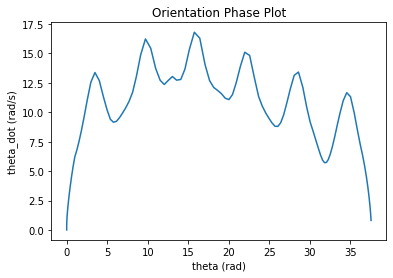

In [58]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

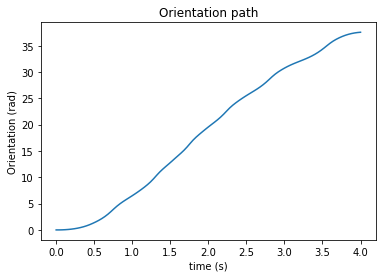

In [59]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

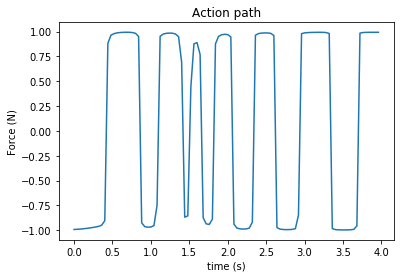

In [60]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

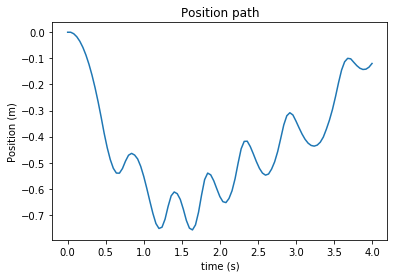

In [61]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

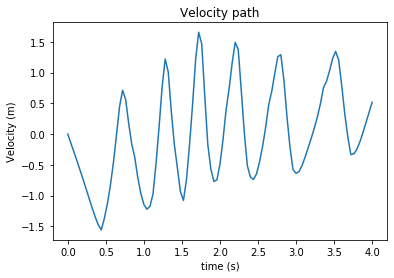

In [62]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

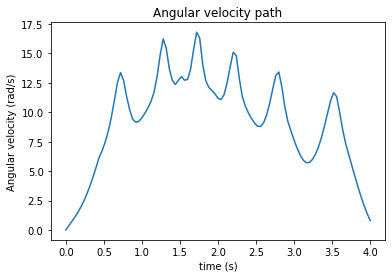

In [63]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

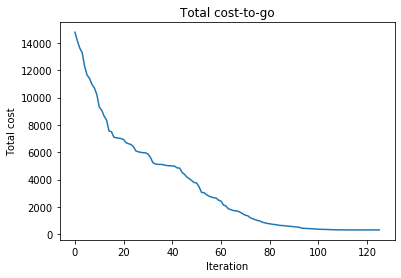

In [64]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")